# 2025 CVE Time Series Forecasting using Kalman Filter

Backgound on the Kalman Filter:
https://en.wikipedia.org/wiki/Kalman_filter 

Python Library Used: 
https://unit8co.github.io/darts/

In [1]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import datetime
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import re
import sys
import uuid
import warnings
import pandas as pd
from darts import TimeSeries
from darts.models import KalmanForecaster
import matplotlib.pyplot as plt

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [2]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            try:
                cve_tag = entry['cve']['cveTags'][0]['tags'] 
            except IndexError:
                cve_tag = np.nan   
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Tag' : cve_tag,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
pastdata = ((nvd['Published'] > '2017-01-01') & (nvd['Published']  < '2025-01-01'))
thisyear = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2026-01-01'))
nvd_2024 = nvd.loc[thisyear]
nvd = nvd.loc[pastdata]
startdate = date(2017, 1, 1)
enddate  = date(2026, 1, 1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [3]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **194461**<br />Average CVEs Per Day: **85.82**<br />Average CVSS Score: **6.91**

In [4]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
monthly = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
monthly_cves = pd.DataFrame(monthly)
monthly_cves.columns = ['Count']
monthly_cves = monthly_cves .reset_index()
monthly_cves = monthly_cves.rename(columns={"Published" : "Month" ,"Count": "CVEs"})
monthly_cves['Month'] = monthly_cves['Month'].astype(str)
monthly_cves['Month'] = pd.to_datetime(monthly_cves['Month'])

<Axes: xlabel='Month'>

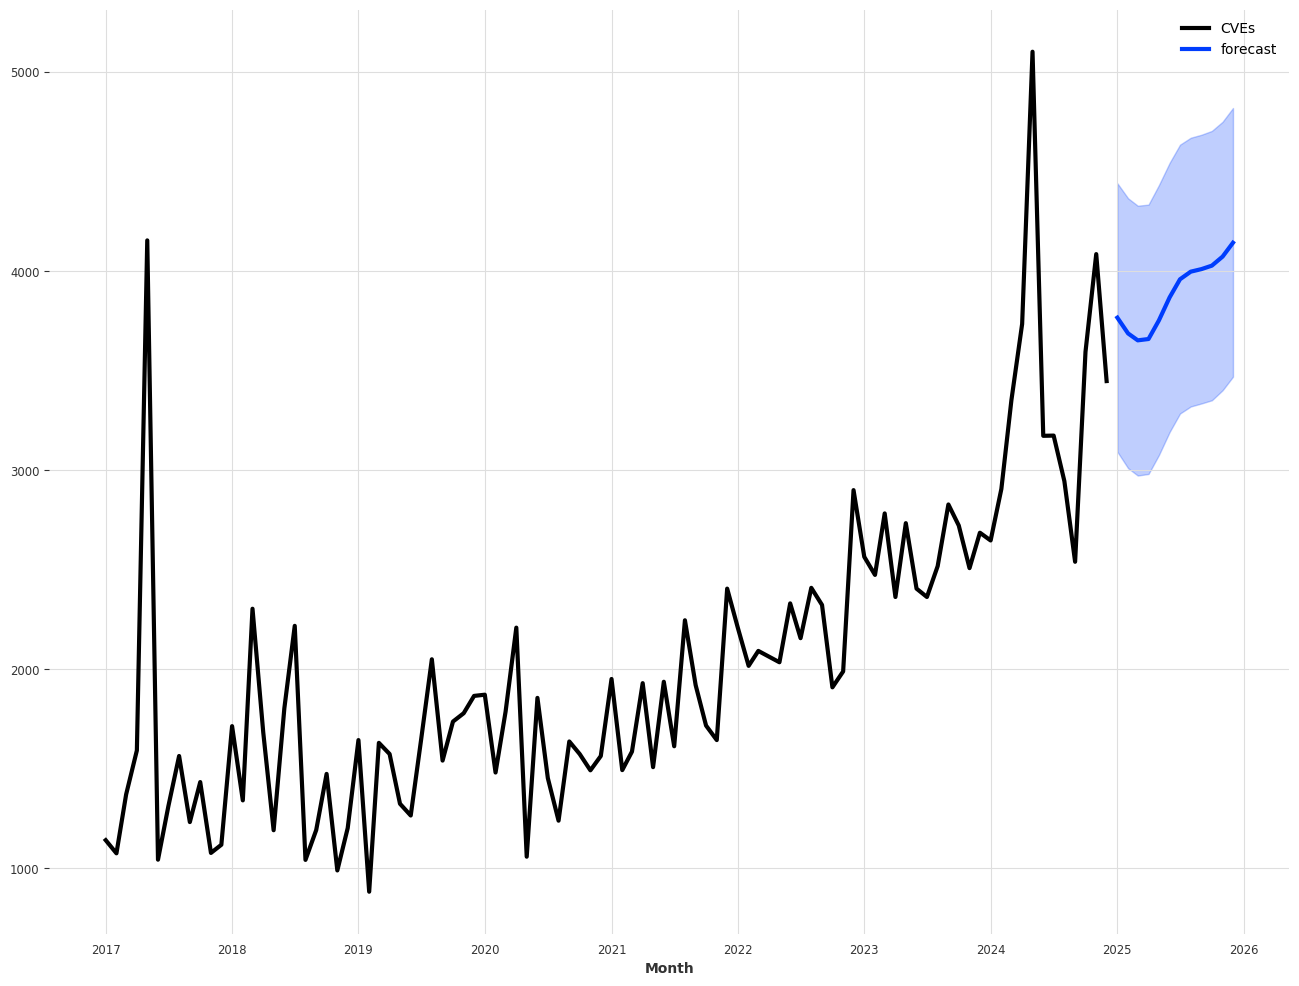

In [5]:
train = TimeSeries.from_dataframe(monthly_cves,"Month", "CVEs")
model = KalmanForecaster(dim_x=4)
model.fit(train)
pred = model.predict(n=12, num_samples=100000)

plt.figure(figsize=(16,12))
train.plot(lw=3)
pred.plot(lw=3, label='forecast')

In [6]:
darts_df = pred.pd_dataframe();
darts_monthly = pred.pd_dataframe().mean(axis = 1).round(0)
darts_monthly = darts_monthly.to_frame()
darts_monthly = darts_monthly.reset_index()
darts_monthly = darts_monthly.rename(columns={0 : "CVEs Predicted"})
darts_monthly['Month'] = darts_monthly['Month'].dt.month_name()
darts_monthly

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Month,CVEs Predicted
0,January,3767.0
1,February,3688.0
2,March,3653.0
3,April,3657.0
4,May,3754.0
5,June,3867.0
6,July,3960.0
7,August,3998.0
8,September,4011.0
9,October,4028.0


In [7]:
darts_monthly['CVEs Predicted'].sum()

46601.0

In [8]:
monthly_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
monthly_cves_2024 = pd.DataFrame(monthly_2024)
monthly_cves_2024.columns = ['Count']
monthly_cves_2024 = monthly_cves_2024.reset_index()
monthly_cves_2024 = monthly_cves_2024.rename(columns={"Published" : "Month" ,"Count": "CVEs Actual"})
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].astype(str)
monthly_cves_2024['Month'] = pd.to_datetime(monthly_cves_2024['Month'])
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].dt.month_name()
monthly_cves_2024

,Month,CVEs Actual
0,January,4415
1,February,2384


In [9]:
validation_df = pd.merge(
    monthly_cves_2024,
    darts_monthly,
    how="outer",
    on='Month',
)

month_categories = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December', 'Total']

validation_df['Month'] = pd.Categorical(validation_df['Month'], categories = month_categories, ordered = True)
validation_df = validation_df.sort_values(by='Month')


validation_df

,Month,CVEs Actual,CVEs Predicted
4,January,4415.0,3767.0
3,February,2384.0,3688.0
7,March,NaN,3653.0
0,April,NaN,3657.0
8,May,NaN,3754.0
6,June,NaN,3867.0
5,July,NaN,3960.0
1,August,NaN,3998.0
11,September,NaN,4011.0
10,October,NaN,4028.0


In [10]:
validation_df = validation_df[['Month', 'CVEs Predicted', 'CVEs Actual']]
validation_df['Difference'] = validation_df['CVEs Actual'] -  validation_df['CVEs Predicted'] 

numeric_df = validation_df.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)

validation_df = pd.concat([validation_df, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)
validation_df['CVEs Actual'].fillna(0, inplace=True)
validation_df['Difference'].fillna(0, inplace=True)


In [11]:

def percentage_change(col1,col2):
    return ((col2 / col1) * 100).round(0)

validation_df['Precentage'] = percentage_change(validation_df['CVEs Predicted'],validation_df['CVEs Actual'])   

validation_df['Precentage'].fillna(0, inplace=True)
validation_df.at[12,'Month']='Total'



In [12]:
darts_total = darts_monthly.copy()

darts_total.fillna(0) 
numeric_df = darts_total.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)
darts_total = pd.concat([darts_total, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)

darts_total.at[12,'Month']='Total'
darts_total

,Month,CVEs Predicted
0,January,3767.0
1,February,3688.0
2,March,3653.0
3,April,3657.0
4,May,3754.0
5,June,3867.0
6,July,3960.0
7,August,3998.0
8,September,4011.0
9,October,4028.0


In [13]:
validation_df['CVEs Actual'].fillna(0, inplace=True)
validation_df['Difference'].fillna(0, inplace=True)
validation_df['Precentage'].fillna(0, inplace=True)
validation_df

,Month,CVEs Predicted,CVEs Actual,Difference,Precentage
0,January,3767.0,4415.0,648.0,117.0
1,February,3688.0,2384.0,-1304.0,65.0
2,March,3653.0,0.0,0.0,0.0
3,April,3657.0,0.0,0.0,0.0
4,May,3754.0,0.0,0.0,0.0
5,June,3867.0,0.0,0.0,0.0
6,July,3960.0,0.0,0.0,0.0
7,August,3998.0,0.0,0.0,0.0
8,September,4011.0,0.0,0.0,0.0
9,October,4028.0,0.0,0.0,0.0
